### Sort-of-CLEVR

Sort-of-CLEVR consists of images of 2D colored shapes along with questions and answers about the
images. Each image has a total of 6 objects, where each object is a randomly chosen shape (square
or circle). We used 6 colors (red, blue, green, orange, yellow, gray) to unambiguously identify each
object.

In [1]:
import cv2
import os
import numpy as np
import random
import pickle
import warnings
#import argparse
from matplotlib import pyplot as plt

In [2]:
import easydict
args = easydict.EasyDict({
        "seed": 1,
        "t_subtype": -1, # for selecting the sub-questions. If set to negative, it will randomly select the type.
})

In [3]:
random.seed(args.seed)
np.random.seed(args.seed)

In [4]:
train_size = 9800//10
test_size = 200//10
img_size = 75 # width and height of the image
size = 5 # size of each object in the image 
question_size = 18  ## 2 x (6 for one-hot vector of color), 3 for question type, 3 for question subtype
q_type_idx = 12 #+0 for non-relational, +1 for Binary Relational questions, +2 for Ternary Relational questions
sub_q_type_idx = 15
"""Answer : [yes, no, rectangle, circle, r, g, b, o, k, y]"""

nb_questions = 10
dirs = './data'

colors = [
    (0,0,255),##r
    (0,255,0),##g
    (255,0,0),##b
    (0,156,255),##o
    (128,128,128),##k
    (0,255,255)##y
]


try:
    os.makedirs(dirs)
except:
    print('directory {} already exists'.format(dirs))


directory ./data already exists


In [5]:
def center_generate(objects):
    while True:
        pas = True
        center = np.random.randint(0+size, img_size - size, 2)        
        if len(objects) > 0:
            for name,c,shape in objects:
                if ((center - c) ** 2).sum() < ((size * 2) ** 2):
                    pas = False
        if pas:
            return center

In [6]:
[center_generate([]) for _ in range(5)]

[array([42, 17]),
 array([14, 10]),
 array([69, 21]),
 array([ 6, 11]),
 array([30, 55])]

In [7]:
center = center_generate([])
print(center)

[25 23]


In [8]:
def test_img(n_figs=5):
    vimg=[]
    vobject=[]
    for _ in range(n_figs):
        objects = []
        img = np.ones((img_size,img_size,3)) * 255.0
        
        for color_id,color in enumerate(colors):  
            center = center_generate(objects)
            
            if random.random()<0.5:
                start = (center[0]-size, center[1]-size)
                end = (center[0]+size, center[1]+size)
                cv2.rectangle(img, start, end, color, -1)
                objects.append((color_id,center,'r'))
            else:
                center_ = (center[0], center[1])
                cv2.circle(img, center_, size, color, -1)
                objects.append((color_id,center,'c'))
        img = img/255.

        vimg.append(img)
        vobject.append(objects)
    return vimg, vobject


* Just for the test <br>
: 모든 색깔에 대해 0.5의 확률로 네모나 원을 그림

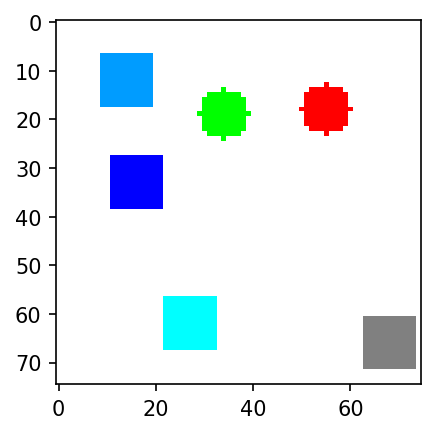

In [9]:
ntest = 1
plt.figure(figsize=(3, 3), dpi=150)
vimg, vobjects = test_img(ntest)
plt.imshow(vimg[0])
plt.tight_layout()
plt.savefig('images/example.png')
plt.show()

In [10]:
print(vobjects[0]) # (color_id,center,'rect' / 'circle')

[(0, array([16, 33]), 'r'), (1, array([34, 19]), 'c'), (2, array([55, 18]), 'c'), (3, array([14, 12]), 'r'), (4, array([68, 66]), 'r'), (5, array([27, 62]), 'r')]


In [11]:
color = random.randint(0,5)
print('color={}'.format(color))

objects = vobjects[0]
my_obj = objects[color][1]  # center 점을 my_obj라고 부름
                            # color는 unique하게 부여되기 때문에 객체 인덱스역할
print(my_obj)

color=5
[27 62]


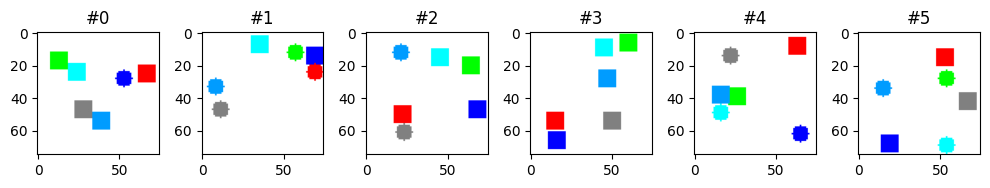

In [22]:
ntest = 6
vimg, vobjects = test_img(ntest)
plt.figure(figsize=(10,2.5), dpi=100)
for i, img in enumerate(vimg):
    plt.subplot(1, ntest, i+1) 
    plt.imshow(img)
    plt.title('#{}'.format(i))

plt.tight_layout()
plt.savefig('images/example2.png')
plt.show()
#vimg[0].shape #(75, 75, 3)

In [13]:
print(img_size,img_size,3)

75 75 3


In [14]:
for i in range(len(vobjects)):
    for k in range(len(vobjects[i])):
        print(vobjects[i][k], colors[vobjects[i][k][0]])
    print()

(0, array([6, 5]), 'r') (0, 0, 255)
(1, array([65, 13]), 'r') (0, 255, 0)
(2, array([18, 52]), 'r') (255, 0, 0)
(3, array([35,  8]), 'c') (0, 156, 255)
(4, array([29, 48]), 'r') (128, 128, 128)
(5, array([46, 20]), 'c') (0, 255, 255)

(0, array([69, 30]), 'c') (0, 0, 255)
(1, array([12, 31]), 'c') (0, 255, 0)
(2, array([30, 27]), 'r') (255, 0, 0)
(3, array([32, 42]), 'c') (0, 156, 255)
(4, array([62, 43]), 'c') (128, 128, 128)
(5, array([39, 15]), 'r') (0, 255, 255)

(0, array([28, 20]), 'r') (0, 0, 255)
(1, array([30, 67]), 'r') (0, 255, 0)
(2, array([51, 37]), 'c') (255, 0, 0)
(3, array([8, 5]), 'r') (0, 156, 255)
(4, array([11, 57]), 'c') (128, 128, 128)
(5, array([ 7, 26]), 'c') (0, 255, 255)

(0, array([12, 48]), 'c') (0, 0, 255)
(1, array([25, 35]), 'c') (0, 255, 0)
(2, array([41, 12]), 'c') (255, 0, 0)
(3, array([50, 62]), 'c') (0, 156, 255)
(4, array([18, 15]), 'c') (128, 128, 128)
(5, array([28, 12]), 'c') (0, 255, 255)

(0, array([29, 25]), 'r') (0, 0, 255)
(1, array([37, 17]

Questions are hard-coded as fixed-length binary strings to reduce the difficulty involved with natural language question-word processing, and thereby remove any confounding difficulty with language parsing.
```
questions = 2 x (6 for one-hot vector of color), 3 for question type(binary, ternary, norel), 3 for question subtype
```
최대 2개의 물체의 관계를 포함하기 위해 2개의 색을 지정할수 있도록 함. no_rel question에서는 1개만 색이 지정되게 됨.

In [15]:
question_size

18

* No-rel questions

In [16]:
norel_questions = []

question = np.zeros((question_size))
print(question)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


* norel_question 예제

In [17]:
#norel_question
color = random.randint(0,5)
question[color] = 1
print(color, '-->', question)
# --> norel_question 이기 때문에, 1개의 객체에 대한 색만 지정. 

question[q_type_idx] = 1 
print(q_type_idx,'-->', question+0, ' (fixed for norel_questions)')

subtype = random.randint(0,2) # 질문 유형 0-> shape, 1-> 중앙보다 왼쪽?, 2-> 중앙보다 오른쪽
question[subtype+sub_q_type_idx] = 1
print(sub_q_type_idx, '+', subtype , '-->', question)

#norel_questions.append(question) 

5 --> [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
12 --> [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]  (fixed for norel_questions)
15 + 1 --> [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]


In [18]:
def build_dataset():
    ''' 하나의 이미지에 들어갈 객체들을 생성하고, 생성된 객체들로부터 Relation 관련 질문을 만든다'''
    objects = [] # 하나의 이미지에 들어갈 여러 객체 생성
    img = np.ones((img_size,img_size,3)) * 255
    for color_id,color in enumerate(colors):  
        center = center_generate(objects)
        if random.random()<0.5:
            start = (center[0]-size, center[1]-size)
            end = (center[0]+size, center[1]+size)
            cv2.rectangle(img, start, end, color, -1)
            objects.append((color_id,center,'r'))
        else:
            center_ = (center[0], center[1])
            cv2.circle(img, center_, size, color, -1)
            objects.append((color_id,center,'c'))


    ternary_questions = []
    binary_questions = []
    norel_questions = []
    ternary_answers = []
    binary_answers = []
    norel_answers = []
    """Non-relational questions"""
    for _ in range(nb_questions):
        question = np.zeros((question_size))
        color = random.randint(0,5)
        question[color] = 1
        question[q_type_idx] = 1
        subtype = random.randint(0,2)
        question[subtype+sub_q_type_idx] = 1
        norel_questions.append(question)
        """Answer : [yes, no, rectangle, circle, r, g, b, o, k, y]"""
        if subtype == 0: 
            #shape 관련 질문
            # 질문 유형 0-> shape, 1-> 중앙보다 왼쪽?, 2-> 중앙보다 오른쪽
            """query shape->rectangle/circle"""
            if objects[color][2] == 'r':
                answer = 2
            else:
                answer = 3

        elif subtype == 1: #위치가 중앙보다 왼쪽인지?
            """query horizontal position->yes/no"""
            """ 두 물체의 중심을 이은 선 근처에 물체가 존재하는가?"""
            if objects[color][1][0] < img_size / 2:
                answer = 0
            else:
                answer = 1

        elif subtype == 2: #위치가 중앙보다 위쪽인지?
            """query vertical position->yes/no"""
            if objects[color][1][1] < img_size / 2:
                answer = 0
            else:
                answer = 1
        norel_answers.append(answer)
    
    """Binary Relational questions"""
    for _ in range(nb_questions):
        question = np.zeros((question_size))
        color = random.randint(0,5)
        question[color] = 1
        question[q_type_idx+1] = 1
        subtype = random.randint(0,2)
        question[subtype+sub_q_type_idx] = 1
        binary_questions.append(question)

        if subtype == 0:
            """closest-to->rectangle/circle""" 
            """가장 가까운 것이 네모냐 원이냐?"""
            
            my_obj = objects[color][1] # color = random.randint(0,5)
            dist_list = [((my_obj - obj[1]) ** 2).sum() for obj in objects]
            
            # https://github.com/kimhc6028/relational-networks/pull/21/commits/8464436122f80227e35b07804747b3e7d164ad25
            dist_list[dist_list.index(0)] = 99999 # 자기 자신 제외
            
            closest = dist_list.index(min(dist_list))
            if objects[closest][2] == 'r':
                answer = 2
            else:
                answer = 3
                
        elif subtype == 1:
            """furthest-from->rectangle/circle"""
            """가장 먼 것이 네모냐 원이냐?""" 
            """ “What is the shape of the object that is farthest from the gray object?”"""
            my_obj = objects[color][1]
            dist_list = [((my_obj - obj[1]) ** 2).sum() for obj in objects]
            furthest = dist_list.index(max(dist_list))
            if objects[furthest][2] == 'r':
                answer = 2
            else:
                answer = 3

        elif subtype == 2:
            """count->1~6""" 
            """“How many objects have the same shape as the green object?”"""
            my_obj = objects[color][2]
            count = -1
            for obj in objects:
                if obj[2] == my_obj: # shape 이 같은지?
                    count +=1 
            answer = count+4
            # https://github.com/kimhc6028/relational-networks/issues/29
            # Answer : [yes, no, rectangle, circle, r, g, b, o, k, y]
        binary_answers.append(answer)

    """Ternary Relational questions"""
    for _ in range(nb_questions):
        question = np.zeros((question_size))
        rnd_colors = np.random.permutation(np.arange(5))
        # 1st object
        color1 = rnd_colors[0]
        question[color1] = 1
        # 2nd object
        color2 = rnd_colors[1]
        question[6 + color2] = 1

        question[q_type_idx + 2] = 1
        
        if args.t_subtype >= 0 and args.t_subtype < 3:
            subtype = args.t_subtype
        else:
            subtype = random.randint(0, 2)

        question[subtype+sub_q_type_idx] = 1 # Ternary-relation 
        ternary_questions.append(question)

        # get coordiantes of object from question
        A = objects[color1][1]
        B = objects[color2][1]

        if subtype == 0:
            """between->1~4"""
            
            between_count = 0 
            # check is any objects lies inside the box
            # A와 B 사이에 몇개의 물체가 들어있는지? 
            for other_obj in objects:
                # skip object A and B (A와 B를 제외한 다른 물체 pick)
                if (other_obj[0] == color1) or (other_obj[0] == color2):
                    continue

                # Get x and y coordinate of third object
                other_objx = other_obj[1][0]
                other_objy = other_obj[1][1]

                if (A[0] <= other_objx <= B[0] and A[1] <= other_objy <= B[1]) or \
                   (A[0] <= other_objx <= B[0] and B[1] <= other_objy <= A[1]) or \
                   (B[0] <= other_objx <= A[0] and B[1] <= other_objy <= A[1]) or \
                   (B[0] <= other_objx <= A[0] and A[1] <= other_objy <= B[1]):
                    between_count += 1

            answer = between_count + 4
            
        elif subtype == 1:
            """is-on-band->yes/no"""
            
            grace_threshold = 12  # half of the size of objects
            epsilon = 1e-10  
            m = (B[1]-A[1])/((B[0]-A[0]) + epsilon ) # add epsilon to prevent dividing by zero
            c = A[1] - (m*A[0])

            answer = 1  # default answer is 'no'

            # check if any object lies on/close the line between object A and object B
            for other_obj in objects:
                # skip object A and B
                if (other_obj[0] == color1) or (other_obj[0] == color2):
                    continue

                other_obj_pos = other_obj[1]
                
                # y = mx + c
                y = (m*other_obj_pos[0]) + c
                if (y - grace_threshold)  <= other_obj_pos[1] <= (y + grace_threshold):
                    answer = 0
                    
        elif subtype == 2:
            """count-obtuse-triangles->1~6"""

            obtuse_count = 0

            # disable warnings
            # the angle computation may fail if the points are on a line
            warnings.filterwarnings("ignore")
            for other_obj in objects:
                # skip object A and B
                if (other_obj[0] == color1) or (other_obj[0] == color2):
                    continue

                # get position of 3rd object
                C = other_obj[1]
                # edge length
                a = np.linalg.norm(B - C)
                b = np.linalg.norm(C - A)
                c = np.linalg.norm(A - B)
                # angles by law of cosine
                alpha = np.rad2deg(np.arccos((b ** 2 + c ** 2 - a ** 2) / (2 * b * c)))
                beta = np.rad2deg(np.arccos((a ** 2 + c ** 2 - b ** 2) / (2 * a * c)))
                gamma = np.rad2deg(np.arccos((a ** 2 + b ** 2 - c ** 2) / (2 * a * b)))
                max_angle = max(alpha, beta, gamma)
                if max_angle >= 90 and max_angle < 180:
                    obtuse_count += 1

            warnings.filterwarnings("default")
            answer = obtuse_count + 4

        ternary_answers.append(answer)

    ternary_relations = (ternary_questions, ternary_answers)
    binary_relations = (binary_questions, binary_answers)
    norelations = (norel_questions, norel_answers)
    
    img = img/255.
    dataset = (img, ternary_relations, binary_relations, norelations)
    return dataset


In [19]:
print('building test datasets....{}'.format(test_size))
test_datasets = [build_dataset() for _ in range(test_size)]

print('building train datasets...{}'.format(train_size))
train_datasets = [build_dataset() for _ in range(train_size)]

building test datasets....20
building train datasets...980


In [20]:
print(np.shape(test_datasets))
print(np.shape(train_datasets))

(20, 4)
(980, 4)


/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [21]:
print('saving datasets...')
filename = os.path.join(dirs,'sort-of-clevr.pickle')
with  open(filename, 'wb') as f:
    pickle.dump((train_datasets, test_datasets), f)
print('datasets saved at {}'.format(filename))

saving datasets...
datasets saved at ./data/sort-of-clevr.pickle


### References

* Relational Networks https://github.com/kimhc6028/relational-networks/blob/master/sort_of_clevr_generator.py